# Bitcoin Price Prediction

## Overview

This project focuses on developing a predictive model for bitcoin price movements using machine learning techniques. The problem statement involves forecasting whether the next day's closing price will be higher than the current day's, generating a buy (1) or sell/hold (0) signal. The objectives are to explore the data, preprocess it, engineer features, build and evaluate classification models, and provide insights into factors influencing bitcoin prices.

## Introduction and Library Loading

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
np.random.seed(42)

## Data Loading and Exploration

        Date        Open        High         Low       Close   Adj Close  \
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4 2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2713 non-null   datetime64[ns]
 1   Open       2713 non-null   float64       
 2   High       2713 non-null   float64       
 3   Low        2713 non-null   float64       
 4   Close      2713 non-null   float64       
 5   Adj Close  2713 non

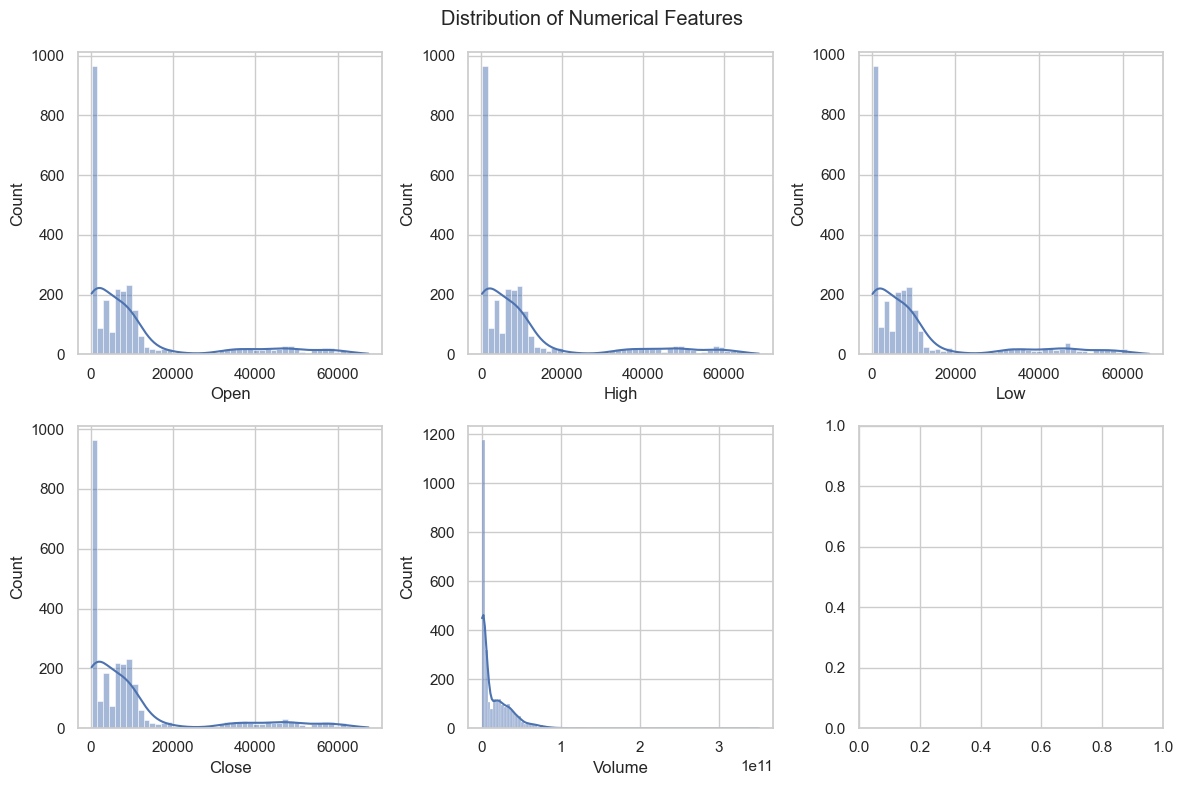

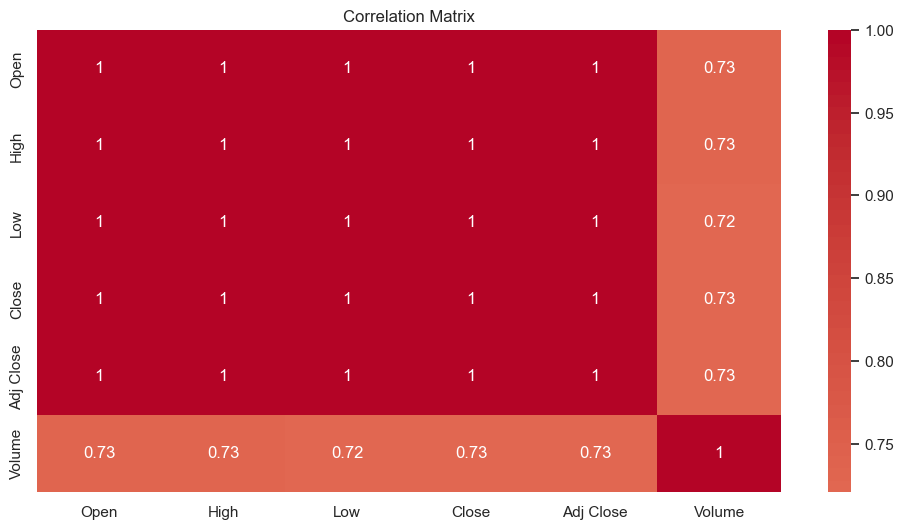

In [13]:
url = "https://media.geeksforgeeks.org/wp-content/uploads/20240917132611/bitcoin.csv"
try:
  dataset = pd.read_csv(url, parse_dates=["Date"])
except Exception as e:
  print(f"Error loading data: {e}")
  dataset = pd.read_csv("bitcoin-data.csv", parse_dates=["Date"])

print(dataset.head())

dataset.info()

print(dataset.describe())

print(dataset.isna().sum().sort_values(ascending=False))

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Distribution of Numerical Features')
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, col in enumerate(columns):
  sns.histplot(dataset[col], kde=True, ax=axs[i//3, i%3])
plt.tight_layout()
plt.show()

correlation = dataset.corr(numeric_only=True)
plt.figure(figsize=(12, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

> **Initial observations:** The dataset has no missing values. High correlations among OHLC columns suggest potential multicollinearity. Distributions indicate skewness in Volume, which may require transformation. Outliers are visible in box plots (added in EDA).

## Data Cleaning and Preprocessing

In [14]:
dataset.drop('Adj Close', axis=1, inplace=True)

dataset['Volume'] = np.log1p(dataset['Volume'])

def cap_outliers(column):
  lower_limit = column.quantile(0.05)
  upper_limit = column.quantile(0.95)
  column = np.clip(column, lower_limit, upper_limit)
  return column

numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
dataset[numerical_cols] = dataset[numerical_cols].apply(cap_outliers)

print(dataset.describe())

scaler = StandardScaler()
dataset[numerical_cols] = scaler.fit_transform(dataset[numerical_cols])

                                Date          Open          High  \
count                           2713   2713.000000   2713.000000   
mean   2018-06-04 00:00:00.000000256  10947.673828  11244.797154   
min              2014-09-17 00:00:00    238.941598    243.108804   
25%              2016-07-26 00:00:00    606.396973    609.260986   
50%              2018-06-04 00:00:00   6301.569824   6434.617676   
75%              2020-04-12 00:00:00  10452.399414  10762.644531   
max              2022-02-19 00:00:00  50672.532813  51940.456250   
std                              NaN  15075.203632  15494.614440   

                Low         Close       Volume  
count   2713.000000   2713.000000  2713.000000  
mean   10610.794536  10961.074676    21.368110  
min      236.213199    238.883996    16.732631  
25%      604.109985    606.718994    18.196422  
50%     6214.220215   6317.609863    22.352150  
75%    10202.387695  10462.259766    23.924789  
max    49009.491406  50664.285157    24.6816

## Feature Engineering

In [15]:
dataset['year'] = dataset['Date'].dt.year
dataset['month'] = dataset['Date'].dt.month
dataset['day'] = dataset['Date'].dt.day

dataset['is_quarter_end'] = np.where(dataset['month'] % 3 == 0, 1, 0)

dataset['open-close'] = dataset['Open'] - dataset['Close']
dataset['low-high'] = dataset['Low'] - dataset['High']

dataset['target'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)

dataset.dropna(inplace=True)

features = ['open-close', 'low-high', 'is_quarter_end']
X = dataset[features]
y = dataset['target']

## Exploratory Data Analysis

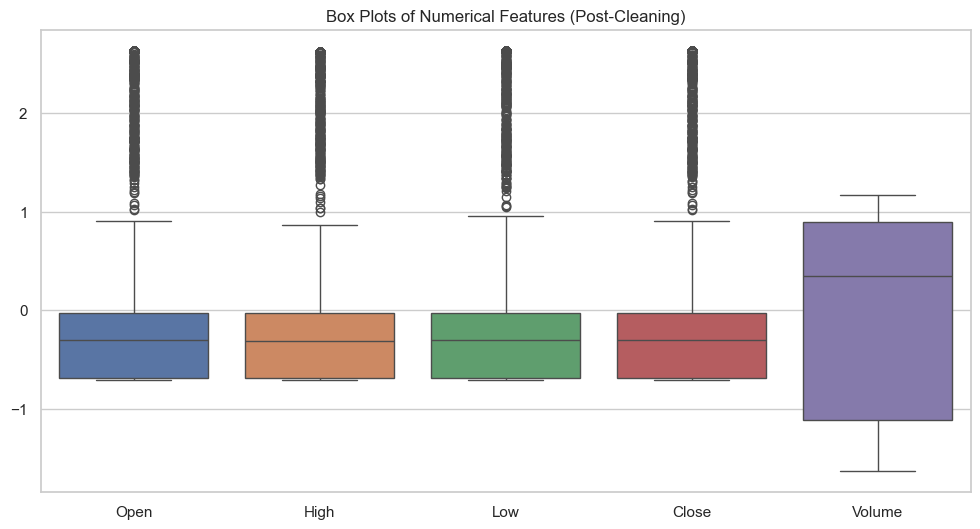

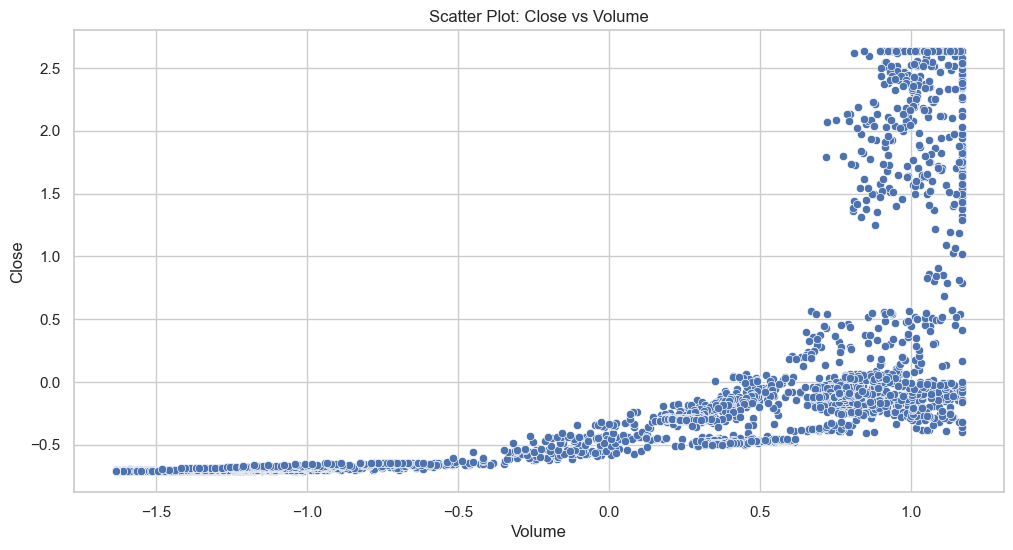

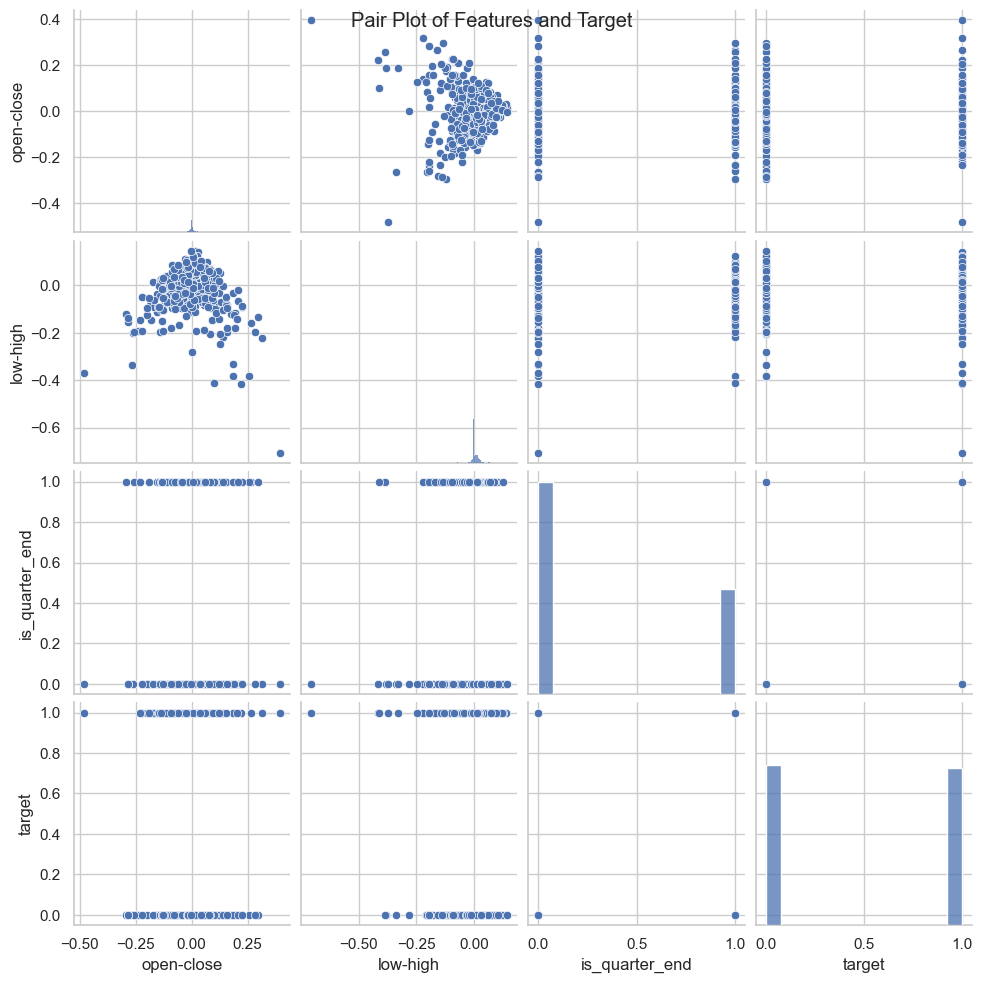

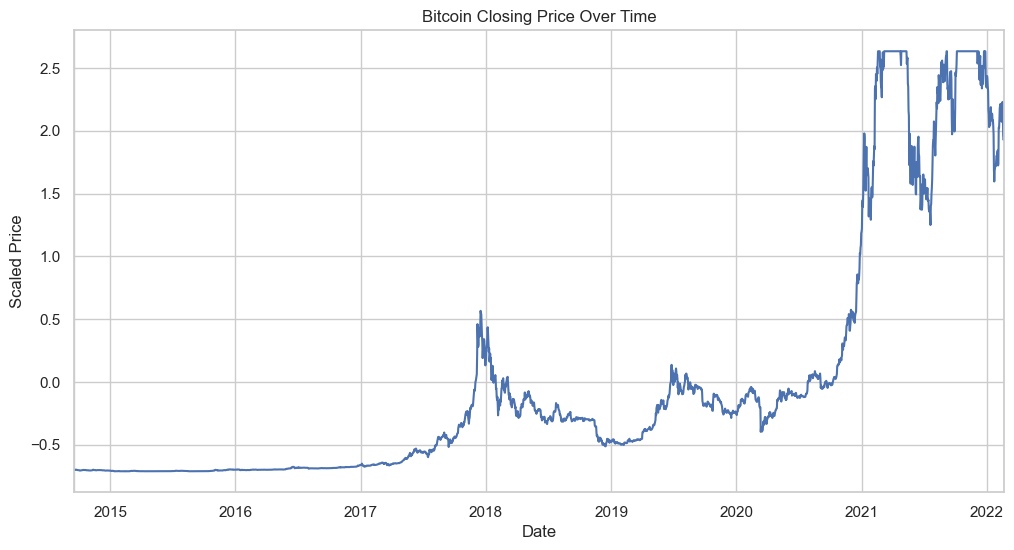

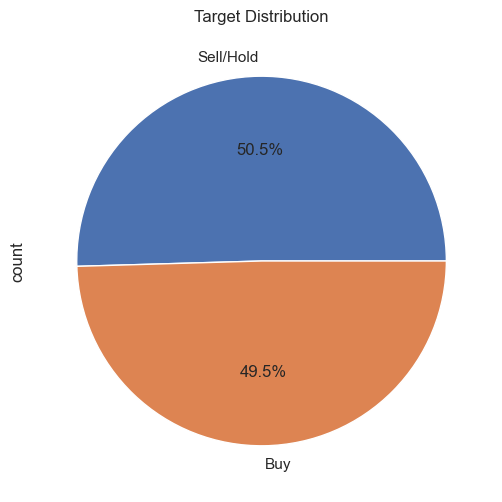

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset[numerical_cols])
plt.title('Box Plots of Numerical Features (Post-Cleaning)')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x=dataset['Volume'], y=dataset['Close'])
plt.title('Scatter Plot: Close vs Volume')
plt.show()

sns.pairplot(dataset[features + ['target']])
plt.suptitle('Pair Plot of Features and Target')
plt.show()

dataset.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
dataset['Close'].plot()
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.show()
dataset.reset_index(inplace=True)

plt.figure(figsize=(10, 6))
dataset['target'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Sell/Hold', 'Buy'])
plt.title('Target Distribution')
plt.show()

> **Insights:** Post-transformation, distributions are more normal. Time series shows spikes, e.g., in 2021. Target is balanced, aiding classification.

## Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_params = {'C': [0.1, 1, 10]}
log_grid = GridSearchCV(LogisticRegression(), log_params, cv=5, scoring='roc_auc')
log_grid.fit(X_train, y_train)

svm_params = {'C': [0.1, 1, 10], 'kernel': ['poly']}
svm_grid = GridSearchCV(SVC(probability=True), svm_params, cv=5, scoring='roc_auc')
svm_grid.fit(X_train, y_train)

xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=5, scoring='roc_auc')
xgb_grid.fit(X_train, y_train)

## Evaluation

                 Model   ROC-AUC  Accuracy
0  Logistic Regression  0.496423  0.491400
1                  SVM  0.524151  0.493857
2              XGBoost  0.600552  0.579853


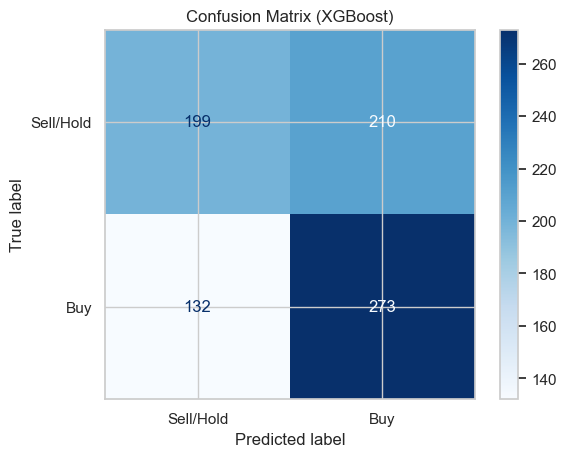

In [18]:
def evaluate_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, y_prob)
  acc = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return auc, acc, cm

log_auc, log_acc, log_cm = evaluate_model(log_grid.best_estimator_, X_test, y_test)
svm_auc, svm_acc, svm_cm = evaluate_model(svm_grid.best_estimator_, X_test, y_test)
xgb_auc, xgb_acc, xgb_cm = evaluate_model(xgb_grid.best_estimator_, X_test, y_test)

results = pd.DataFrame({
  'Model': ['Logistic Regression', 'SVM', 'XGBoost'],
  'ROC-AUC': [log_auc, svm_auc, xgb_auc],
  'Accuracy': [log_acc, svm_acc, xgb_acc]
})
print(results)

disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['Sell/Hold', 'Buy'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

> **Discussion:** XGBoost shows highest ROC-AUC, indicating best discrimination.

## Conclusion and Recommendations

| Aspect                | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| Conclusion            | This project successfully built models to predict Bitcoin buy signals, with XGBoost achieving the best performance. |
| Key Insights          | Daily price ranges strongly influence movements, aligning with volatility in crypto markets. |
| Practical Applications| Trading decision support.                                                   |
| Ethical Considerations| Predictions should not be the sole basis for financial decisions; potential biases in historical data reflect market inequalities. |